In [1]:
library(tidyverse)
library(glmnet)
library(GGally)
install.packages('plotmo')
library(plotmo)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: Formula

Loading required package: plotrix

Loading required package: TeachingDemos



### Question

Can we use only information on the year, time of year, and weather of a given day to make reliable *future* predictions about the popularity of the Capital Bike-sharing System? If so, what trends will this system experience in the future?

This question deals with prediction and involves all non-collinear explanatory variables.

### Download data from the web

In [2]:
raw_data <- read_csv("https://raw.githubusercontent.com/sam-coble/stat301_proj/main/day.csv")
tail(raw_data)

Rows: 731 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (15): instant, season, yr, mnth, holiday, weekday, workingday, weathers...
date  (1): dteday

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
726,2012-12-26,1,1,12,0,3,1,3,0.243333,0.220333,0.823333,0.316546,9,432,441
727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


### Wrangle data into a tidy format

In [3]:
# Remove N/A values
# Remove non-used response variables and obviously collinear explanatory variables
# Rename Year factor levels to be useful
data <- raw_data |> 
    na.omit() |>
    select(-casual, -registered, -atemp) |>
    mutate(yr = recode_factor(as.factor(yr), `0` = "2011", `1` = "2012"))

### Relevant Exploratory Visualization

`summarise()` has grouped output by 'mnth'. You can override using the
`.groups` argument.


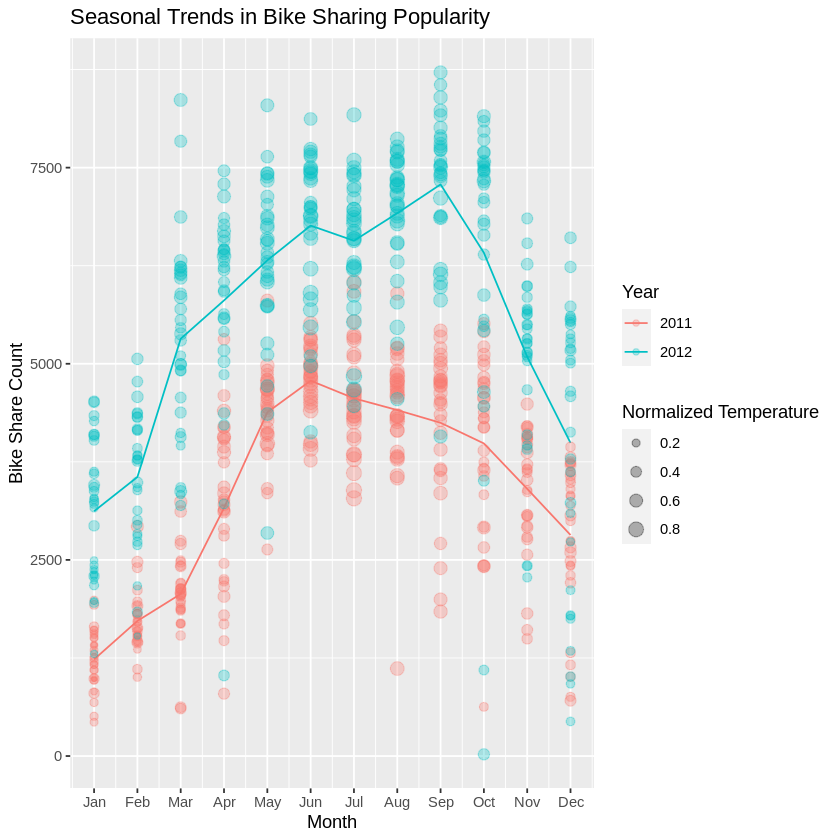

In [4]:
data |>
    group_by(mnth, yr) |>
    summarize(cnt = mean(cnt)) |>
    ggplot(aes(x = mnth, y = cnt, color = yr)) +
    geom_line() +
    geom_point(aes(x = mnth, y = cnt, color = yr, size = temp), data = data, alpha = 0.3) +
    labs(x = "Month", y = "Bike Share Count", color = "Year", size = "Normalized Temperature") +
    ggtitle("Seasonal Trends in Bike Sharing Popularity") +
    scale_x_continuous(breaks=seq(1,12,1), labels= month.abb) +
    scale_size_area(max_size=4)

This plot is relevant and important because it gives us a lot of neccessary information useful in deciding our prediction methodology. We can see from this chart the the response variable is highly cyclical, and thus we must keep in mind that we should use strategies and metrics consistant with time-series data when deciding our methodologies. When testing or validating our models, we need to remember that there is a large difference between in-sample predictions (predicting the past), and out-of-sample predictions (predicting the future). Without this visualization giving us this kind of insight, we could have made testing mistakes that would have darastically overestimated our model's capabilities in the real world.

### Methods/Plan

In order to make accurate predictions of future bike share usage, we will be performing linear regression and LASSO regularization to do feature selection as LASSO is an effective tool to do poisson regression[1]. This should improve test accuracy by removing the chance of overfitting on weather variables that do not affect bike share usage. We will use cross-validation to choose the regularization factor. Additionally, we will attempt to encode the date as a numerical quantity rather than a series of month/year categorical variables. This will hopefully reduce the complexity of the model and prevent overfitting from damaging future predicitons. However, in order to account for the cyclical effects of time, we will do a basis expansion on the day of year by including a new variable `cos(365/2π * dayOfYear + t)` where `t` is the cycle offset chosen by cross-validation. This will appropriately model the trend between time and bike share count, while dramatically reducing the number of parameters in our model (which would otherwise be one for every month/year combination, plus any interaction terms). 

This method assumes that the cycle is perfectly sinusoidal, however, it might be possible to alleviate this assumption in future experiments by including additional basis. This method also assumes that weather and time of year are independent when there is likely a moderate casual factor between them.

A major potential weakness we will have to look out for is potential non-linear trends between explanatory variables and our response. We somewhat took care of this problem with the time/response trend, but non-linearity could exist elsewhere too--especially with the weather-related explanatory variables. This could be a problem as our model would not be able to accurately follow these trends. For example, people might choose to avoid riding bikes when it's too cold, *and* when it's too hot. With this method, we would not accurately model this behavior. If we notice this harms our prediction accuracy, we could potentially fix this problem by adding basis expanions for the non-temporal explanatory variables as well. This would increase the complexiy of our model, but would likely be worth it if it improves prediction accuracy.

Additionally, this method could easily fail if our cross-validation is not performed carefully. If unreasonable values are tested and chosen for our regularization constant or cycle period, our model predictions accuracy could be seriously damaged as many variables could be erroniously selected or deselected, or our modeled cycle frequency could be misaligned with reality. We must be careful when performing cross-validation to ensure a reasonable range of values are tested.

[1] https://onlinelibrary.wiley.com/doi/pdf/10.1111/j.1467-842X.2012.00679.x

### Implementation of a proposed model

In [5]:
# Replace `year`/`month` variables with `daysElapsed`
new_data <- data |> mutate(
    daysElapsed = as.numeric(difftime(dteday, '2011-01-01', units="days"))) |>
    select(-instant, -dteday, -yr, -mnth)

# Training/Testing split where test data is the "future"
future_training_data <- new_data |> 
    filter(daysElapsed < quantile(new_data$daysElapsed, 0.8))
future_testing_data <- new_data |>
    filter(daysElapsed >= quantile(new_data$daysElapsed, 0.8))

head(future_training_data)
nrow(future_training_data)
nrow(future_testing_data)

season,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,daysElapsed
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,6,0,2,0.344167,0.805833,0.1604460,985,0
1,0,0,0,2,0.363478,0.696087,0.2485390,801,1
1,0,1,1,1,0.196364,0.437273,0.2483090,1349,2
1,0,2,1,1,0.200000,0.590435,0.1602960,1562,3
1,0,3,1,1,0.226957,0.436957,0.1869000,1600,4
1,0,4,1,1,0.204348,0.518261,0.0895652,1606,5


[1] 584

[1] 147

In [6]:
set.seed(1234)

# Function to create the new feature column based off of selected offset
createData <- function(data, dayOffset) {
    data |> mutate(
        cosDaysElapsed = cos(2*pi* (daysElapsed - dayOffset) / 365))
}

# Function to fit a lasso model given an offset to use
createModel <- function(data, dayOffset) {
    expanded_data <- createData(data, dayOffset)
    # expanded_data |> scale()
    model <- cv.glmnet(
        x = expanded_data |> select(-cnt) |> scale() |> as.matrix(),
        y = expanded_data |> select(cnt) |> as.matrix(),
        )
    model
}

In [7]:
# Offsets to try during cross validation
offsetsToTry <- seq(-182, 183, 10)

# For each offset, calculate best possible validation error
offsetScores <- map(
    .x = offsetsToTry, 
    .f = ~ {
        model <- createModel(future_training_data, .x)
        model$cvm[s = model$lambda.min]
        })

# Choose best offset and model from scores
bestOffset <- offsetsToTry[which.min(offsetScores)]
bestModel <- createModel(future_training_data, bestOffset)

In [8]:
bestOffset

[1] -2

11 x 1 sparse Matrix of class "dgCMatrix"
                       s1
(Intercept)    4153.59932
season            .      
holiday           .      
weekday           .      
workingday        .      
weathersit     -260.35253
temp            254.61788
hum               .      
windspeed       -49.06222
daysElapsed     863.52464
cosDaysElapsed -625.44589


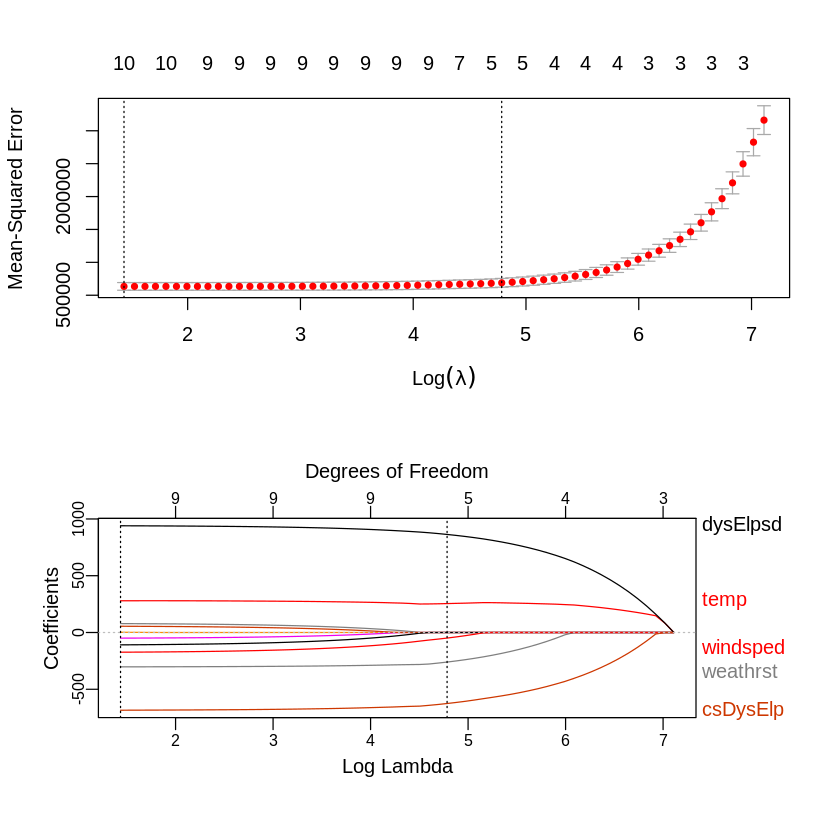

In [9]:
# layout(matrix(c(1,1,2,3), nrow = 2, ncol = 2, byrow = TRUE))
par(mfrow=c(2,1))

plot(bestModel)

plot_glmnet(bestModel$glmnet.fit, "lambda", label = 5)
abline(v = log(bestModel$lambda.min), lty='dotted')
abline(v = log(bestModel$lambda.1se), lty='dotted')

print(coef(bestModel))
# plot(offsetsToTry, offsetScores, type='l')

# Lasso model output

Performing Lasso selection tells us that we achive the best validation scores when using only the coefficients `Days Elapsed`, `Temperature`, `Wind Speed`, `Weather` and `cos(Days Elapsed)`.

### Results

Warning message in training_predictions - future_training_data$cnt:
“longer object length is not a multiple of shorter object length”
Warning message in testing_predictions - future_testing_data$cnt:
“longer object length is not a multiple of shorter object length”


Mean Training Error,Mean Testing Error
<dbl>,<dbl>
1104,2491


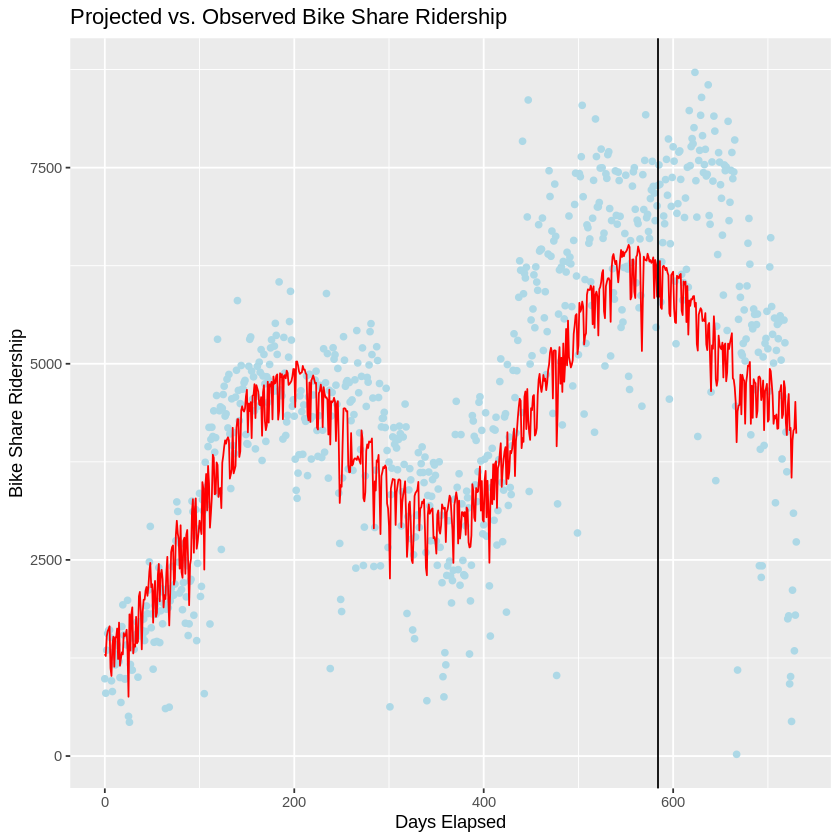

In [14]:
all_predictions <- predict(
    bestModel, 
    createData(new_data, bestOffset) |> 
        select(-cnt) |> 
        scale() |>
        as.matrix())
training_predictions <- predict(
    bestModel, 
    createData(new_data, bestOffset) |> 
        select(-cnt) |> 
        scale() |>
        as.matrix())
testing_predictions <- predict(
    bestModel, 
    createData(new_data, bestOffset) |> 
        select(-cnt) |> 
        scale() |>
        as.matrix())

errors <- tibble(
    `Mean Training Error` = 
        mean(abs(training_predictions - future_training_data$cnt)), 
    `Mean Testing Error` = 
        mean(abs(testing_predictions - future_testing_data$cnt))) |>
    round()
errors

predictions <- new_data |> mutate(predictions = all_predictions)
predictions |>
    ggplot(aes(x = daysElapsed, y = cnt)) +
    geom_point(color="lightblue") +
    geom_line(aes(x = daysElapsed, y = predictions), color="red") +
    labs(x = "Days Elapsed", y = "Bike Share Ridership") +
    ggtitle("Projected vs. Observed Bike Share Ridership") +
    geom_vline(aes(xintercept= quantile(new_data$daysElapsed, 0.8)))

### Interpretation of results

These results are extremely promising. Given the increase in variance of our response as time increases, we manage to predict ridership with remarkable accuracy using just time and weather information. Our mean testing error is 2500, which is approximately +/- 40% on our testing set. This is about what I expected. Our question is answered as we *are* able to rely on this model going forward if we can make good estimates about future weather trends!

### Sources:

Dataset used: https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset